# Vietnamese Legal LLM Model Evaluation

Notebook này dùng để evaluate fine-tuned Llama-3.1-8B model trên test set.

## Setup
- **GPU**: T4 (15GB VRAM)
- **Model**: Fine-tuned Llama-3.1-8B từ DigitalOcean Spaces
- **Test Data**: legal-datalake/process_data/finetune_data/splits/test.jsonl
- **Metrics**: Loss, Perplexity, ROUGE-L, ROUGE-1, ROUGE-2

## 1. Install Dependencies

In [1]:
%%capture
# Install Unsloth for efficient inference on T4
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps xformers trl peft accelerate bitsandbytes

# Install boto3 for DigitalOcean Spaces
!pip install boto3

# Install evaluation metrics
!pip install rouge-score datasets evaluate

## 2. Setup DigitalOcean Spaces Credentials

⚠️ **Quan trọng**: Nhập credentials của bạn vào đây

In [2]:
import os
from getpass import getpass

# Nhập credentials (sẽ được ẩn khi nhập)
DO_SPACES_KEY = getpass('DigitalOcean Spaces Access Key: ')
DO_SPACES_SECRET = getpass('DigitalOcean Spaces Secret Key: ')
DO_SPACES_REGION = 'sfo3'  # Hoặc region của bạn
DO_SPACES_BUCKET = 'legal-datalake'

# Set environment variables
os.environ['DO_SPACES_KEY'] = DO_SPACES_KEY
os.environ['DO_SPACES_SECRET'] = DO_SPACES_SECRET

print("✅ Credentials đã được thiết lập")

DigitalOcean Spaces Access Key: ··········
DigitalOcean Spaces Secret Key: ··········
✅ Credentials đã được thiết lập


## 3. Download Model và Test Data từ DigitalOcean Spaces

In [3]:
import boto3
from pathlib import Path
import json
from tqdm import tqdm

# Initialize S3 client for DigitalOcean Spaces
session = boto3.session.Session()
client = session.client('s3',
                       region_name=DO_SPACES_REGION,
                       endpoint_url=f'https://{DO_SPACES_REGION}.digitaloceanspaces.com',
                       aws_access_key_id=DO_SPACES_KEY,
                       aws_secret_access_key=DO_SPACES_SECRET)

def download_file_from_spaces(spaces_path, local_path):
    """Download file từ DigitalOcean Spaces"""
    try:
        # Tạo thư mục nếu chưa tồn tại
        Path(local_path).parent.mkdir(parents=True, exist_ok=True)

        # Download file
        print(f"Downloading {spaces_path}...")
        client.download_file(DO_SPACES_BUCKET, spaces_path, local_path)
        print(f"✅ Downloaded to {local_path}")
        return True
    except Exception as e:
        print(f"❌ Error downloading {spaces_path}: {e}")
        return False

def download_directory_from_spaces(spaces_prefix, local_dir):
    """Download toàn bộ thư mục từ Spaces"""
    try:
        # List all objects with prefix
        paginator = client.get_paginator('list_objects_v2')
        pages = paginator.paginate(Bucket=DO_SPACES_BUCKET, Prefix=spaces_prefix)

        files_to_download = []
        for page in pages:
            if 'Contents' in page:
                files_to_download.extend(page['Contents'])

        print(f"Found {len(files_to_download)} files to download")

        # Download each file
        for obj in tqdm(files_to_download, desc="Downloading model"):
            spaces_path = obj['Key']
            # Create local path
            relative_path = spaces_path[len(spaces_prefix):].lstrip('/')
            local_path = Path(local_dir) / relative_path

            # Skip if directory
            if spaces_path.endswith('/'):
                continue

            # Download
            local_path.parent.mkdir(parents=True, exist_ok=True)
            client.download_file(DO_SPACES_BUCKET, spaces_path, str(local_path))

        print(f"✅ Downloaded {len(files_to_download)} files to {local_dir}")
        return True
    except Exception as e:
        print(f"❌ Error downloading directory: {e}")
        return False

print("🔗 DigitalOcean Spaces client initialized")

🔗 DigitalOcean Spaces client initialized


In [4]:
# Download test data
test_data_path = "process_data/finetune_data/splits/test.jsonl"
local_test_path = "./data/test.jsonl"

download_file_from_spaces(test_data_path, local_test_path)

✅ Downloaded to ./data/test.jsonl


True

In [5]:
# List available models trong Spaces
print("📦 Listing available models in Spaces...")

try:
    response = client.list_objects_v2(
        Bucket=DO_SPACES_BUCKET,
        Prefix='models/',
        Delimiter='/'
    )

    if 'CommonPrefixes' in response:
        models = [prefix['Prefix'] for prefix in response['CommonPrefixes']]
        print(f"\nFound {len(models)} model(s):")
        for i, model in enumerate(models, 1):
            model_name = model.rstrip('/').split('/')[-1]
            print(f"{i}. {model_name}")

        # Lấy model mới nhất (hoặc bạn có thể chọn)
        latest_model = models[-1]  # Model cuối cùng (thường là mới nhất)
        print(f"\n📥 Will download: {latest_model}")

        # Save model path để dùng sau
        MODEL_SPACES_PATH = latest_model
    else:
        print("❌ No models found in Spaces")
        MODEL_SPACES_PATH = None

except Exception as e:
    print(f"❌ Error listing models: {e}")
    MODEL_SPACES_PATH = None

📦 Listing available models in Spaces...

Found 1 model(s):
1. vietnamese-legal-llama-20251111_115138

📥 Will download: models/vietnamese-legal-llama-20251111_115138/


In [6]:
# Download model (nếu cần chọn model khác, update MODEL_SPACES_PATH)
# Ví dụ: MODEL_SPACES_PATH = "models/vietnamese-legal-llama-20240101_120000/"

if MODEL_SPACES_PATH:
    local_model_dir = "./model"
    download_directory_from_spaces(MODEL_SPACES_PATH, local_model_dir)
else:
    print("⚠️ Please set MODEL_SPACES_PATH manually")
    # MODEL_SPACES_PATH = "models/your-model-name/"
    # download_directory_from_spaces(MODEL_SPACES_PATH, "./model")

Found 14 files to download


✅ Downloaded 14 files to ./model


## 4. Load Test Dataset

In [7]:
import json
from datasets import Dataset

# Load test data
test_data = []
with open(local_test_path, 'r', encoding='utf-8') as f:
    for line in f:
        test_data.append(json.loads(line))

print(f"📊 Loaded {len(test_data)} test examples")

# Convert to HuggingFace Dataset
test_dataset = Dataset.from_list(test_data)

# Show example
print("\n📄 Example test case:")
print(f"Instruction: {test_data[0]['instruction'][:100]}...")
print(f"Input: {test_data[0]['input'][:100]}...")
print(f"Output: {test_data[0]['output'][:100]}...")

📊 Loaded 9753 test examples

📄 Example test case:
Instruction: Trả lời câu hỏi pháp luật sau:...
Input: Bố thường xuyên đánh mẹ khiến cuộc sống gia đình tôi không hạnh phúc, căng thẳng nhiều năm qua. Chún...
Output: Theo Điều 51 Luật Hôn nhân và Gia đình năm 2014 (có hiệu lực từ ngày 1/1/2015), quyền yêu cầu giải q...


## 5. Load Model với Unsloth (Optimized for T4)

In [8]:
import torch
from unsloth import FastLanguageModel

# T4 GPU có 15GB VRAM - sử dụng cấu hình tối ưu
max_seq_length = 2048  # Giảm từ 8192 để phù hợp với T4
dtype = None  # Auto-detect
load_in_4bit = True  # 4-bit quantization để tiết kiệm VRAM trên T4

print(f"🔧 Loading model from {local_model_dir}...")
print(f"   - Max sequence length: {max_seq_length}")
print(f"   - 4-bit quantization: {load_in_4bit}")
print(f"   - GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

# Load model
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=local_model_dir,
    max_seq_length=max_seq_length,
    dtype=dtype,
    load_in_4bit=load_in_4bit,
)

# Enable fast inference mode
FastLanguageModel.for_inference(model)

print("✅ Model loaded successfully!")

# Check GPU memory
if torch.cuda.is_available():
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
    gpu_allocated = torch.cuda.memory_allocated(0) / 1024**3
    print(f"🔋 GPU Memory: {gpu_allocated:.2f}GB / {gpu_memory:.2f}GB")

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
🔧 Loading model from ./model...
   - Max sequence length: 2048
   - 4-bit quantization: True
   - GPU: Tesla T4
==((====))==  Unsloth 2025.11.3: Fast Llama patching. Transformers: 4.57.1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Model loaded successfully!
🔋 GPU Memory: 5.34GB / 14.74GB


## 6. Format Test Data

In [9]:
def format_chat_template(instruction, input_text):
    """Format input theo Llama-3.1 chat template"""
    user_input = f"{instruction} {input_text}"

    text = f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a helpful assistant that answers questions about Vietnamese law.<|eot_id|><|start_header_id|>user<|end_header_id|>

{user_input}<|eot_id|><|start_header_id|>assistant<|end_header_id|>

"""
    return text

# Test formatting
example = test_data[0]
formatted_input = format_chat_template(example['instruction'], example['input'])
print("📝 Formatted input example:")
print(formatted_input[:300] + "...")

📝 Formatted input example:
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a helpful assistant that answers questions about Vietnamese law.<|eot_id|><|start_header_id|>user<|end_header_id|>

Trả lời câu hỏi pháp luật sau: Bố thường xuyên đánh mẹ khiến cuộc sống gia đình tôi không hạnh phúc, căng thẳng nhi...


## 7. Evaluation Metrics Setup

In [10]:
from rouge_score import rouge_scorer
import numpy as np
from tqdm import tqdm
import torch.nn as nn

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=False)

def calculate_perplexity(model, tokenizer, text):
    """
    Calculate perplexity for a given text
    FIX: Tính loss manually để tránh lỗi gradient checkpointing
    """
    encodings = tokenizer(text, return_tensors='pt', truncation=True, max_length=max_seq_length)

    model.eval()  # Ensure model is in eval mode
    with torch.no_grad():
        input_ids = encodings.input_ids.to(model.device)

        # Get logits without computing loss (tránh lỗi gradient checkpointing)
        outputs = model(input_ids)
        logits = outputs.logits

        # Tính loss manually
        shift_logits = logits[..., :-1, :].contiguous()
        shift_labels = input_ids[..., 1:].contiguous()

        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(
            shift_logits.view(-1, shift_logits.size(-1)),
            shift_labels.view(-1)
        )

        perplexity = torch.exp(loss)

    return perplexity.item(), loss.item()

def generate_response(model, tokenizer, prompt, max_new_tokens=512):
    """Generate response từ model"""
    inputs = tokenizer(prompt, return_tensors='pt', truncation=True, max_length=max_seq_length)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    model.eval()  # Ensure model is in eval mode
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.7,
            top_p=0.9,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id,
            use_cache=True,  # Enable KV cache for faster generation
        )

    # Decode response (only the generated part)
    response = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
    return response

print("✅ Evaluation metrics setup complete")
print("🔧 Fixed gradient checkpointing issue")

✅ Evaluation metrics setup complete
🔧 Fixed gradient checkpointing issue


## 8. Run Evaluation

Đánh giá model trên test set với các metrics:
- **Loss**: Cross-entropy loss
- **Perplexity**: exp(loss) - đo độ "confused" của model
- **ROUGE-1**: Overlap của unigrams
- **ROUGE-2**: Overlap của bigrams  
- **ROUGE-L**: Longest common subsequence

In [11]:
# Evaluation settings - GIỚI HẠN 1000 SAMPLES
num_samples = min(600, len(test_data))  # Giới hạn tối đa 1000 samples

print(f"🧪 Evaluating on {num_samples} test samples (out of {len(test_data)} total)")
print("⏳ This may take a while (~30-60 minutes for 1000 samples)...\n")

# Storage for metrics
results = {
    'losses': [],
    'perplexities': [],
    'rouge1_f': [],
    'rouge2_f': [],
    'rougeL_f': [],
    'predictions': [],
    'references': [],
}

# Run evaluation
for i in tqdm(range(num_samples), desc="Evaluating"):
    try:
        example = test_data[i]

        # Format input
        prompt = format_chat_template(example['instruction'], example['input'])
        reference = example['output']

        # Calculate perplexity and loss (FIX: không dùng labels để tránh lỗi)
        full_text = prompt + reference + "<|eot_id|>"
        perplexity, loss = calculate_perplexity(model, tokenizer, full_text)
        results['perplexities'].append(perplexity)
        results['losses'].append(loss)

        # Generate prediction
        prediction = generate_response(model, tokenizer, prompt, max_new_tokens=512)

        # Calculate ROUGE scores
        rouge_scores = scorer.score(reference, prediction)
        results['rouge1_f'].append(rouge_scores['rouge1'].fmeasure)
        results['rouge2_f'].append(rouge_scores['rouge2'].fmeasure)
        results['rougeL_f'].append(rouge_scores['rougeL'].fmeasure)

        # Store predictions and references
        results['predictions'].append(prediction)
        results['references'].append(reference)

        # Clear GPU cache periodically
        if (i + 1) % 10 == 0:
            torch.cuda.empty_cache()

    except Exception as e:
        print(f"\n⚠️ Error at sample {i}: {e}")
        print(f"Skipping sample {i}...")
        continue

print(f"\n✅ Evaluation complete! Successfully evaluated {len(results['predictions'])} samples")

🧪 Evaluating on 600 test samples (out of 9753 total)
⏳ This may take a while (~30-60 minutes for 1000 samples)...



Evaluating: 100%|██████████| 600/600 [4:22:01<00:00, 26.20s/it]


✅ Evaluation complete! Successfully evaluated 600 samples


## 9. Results Summary

In [12]:
# Calculate average metrics
avg_loss = np.mean(results['losses'])
avg_perplexity = np.mean(results['perplexities'])
avg_rouge1 = np.mean(results['rouge1_f'])
avg_rouge2 = np.mean(results['rouge2_f'])
avg_rougeL = np.mean(results['rougeL_f'])

# Calculate standard deviations
std_loss = np.std(results['losses'])
std_perplexity = np.std(results['perplexities'])
std_rouge1 = np.std(results['rouge1_f'])
std_rouge2 = np.std(results['rouge2_f'])
std_rougeL = np.std(results['rougeL_f'])

# Print results
print("="*80)
print("📊 EVALUATION RESULTS")
print("="*80)
print(f"🧪 Successfully evaluated: {len(results['predictions'])} samples (out of {len(test_data)} total)")
print(f"\n📉 Loss & Perplexity:")
print(f"   Average Loss: {avg_loss:.4f} (±{std_loss:.4f})")
print(f"   Average Perplexity: {avg_perplexity:.4f} (±{std_perplexity:.4f})")
print(f"\n📝 ROUGE Scores:")
print(f"   ROUGE-1 F1: {avg_rouge1:.4f} (±{std_rouge1:.4f})")
print(f"   ROUGE-2 F1: {avg_rouge2:.4f} (±{std_rouge2:.4f})")
print(f"   ROUGE-L F1: {avg_rougeL:.4f} (±{std_rougeL:.4f})")
print("="*80)

# Save results to file
results_summary = {
    'num_samples_evaluated': len(results['predictions']),
    'total_samples': len(test_data),
    'avg_loss': float(avg_loss),
    'std_loss': float(std_loss),
    'avg_perplexity': float(avg_perplexity),
    'std_perplexity': float(std_perplexity),
    'avg_rouge1_f1': float(avg_rouge1),
    'std_rouge1_f1': float(std_rouge1),
    'avg_rouge2_f1': float(avg_rouge2),
    'std_rouge2_f1': float(std_rouge2),
    'avg_rougeL_f1': float(avg_rougeL),
    'std_rougeL_f1': float(std_rougeL),
    'model_path': MODEL_SPACES_PATH,
}

with open('evaluation_results.json', 'w', encoding='utf-8') as f:
    json.dump(results_summary, f, indent=2, ensure_ascii=False)

print("\n💾 Results saved to evaluation_results.json")

📊 EVALUATION RESULTS
🧪 Successfully evaluated: 600 samples (out of 9753 total)

📉 Loss & Perplexity:
   Average Loss: 0.8321 (±0.4751)
   Average Perplexity: 2.6264 (±1.7217)

📝 ROUGE Scores:
   ROUGE-1 F1: 0.5556 (±0.2052)
   ROUGE-2 F1: 0.3492 (±0.1629)
   ROUGE-L F1: 0.3603 (±0.1436)

💾 Results saved to evaluation_results.json


## 10. Visualize Results

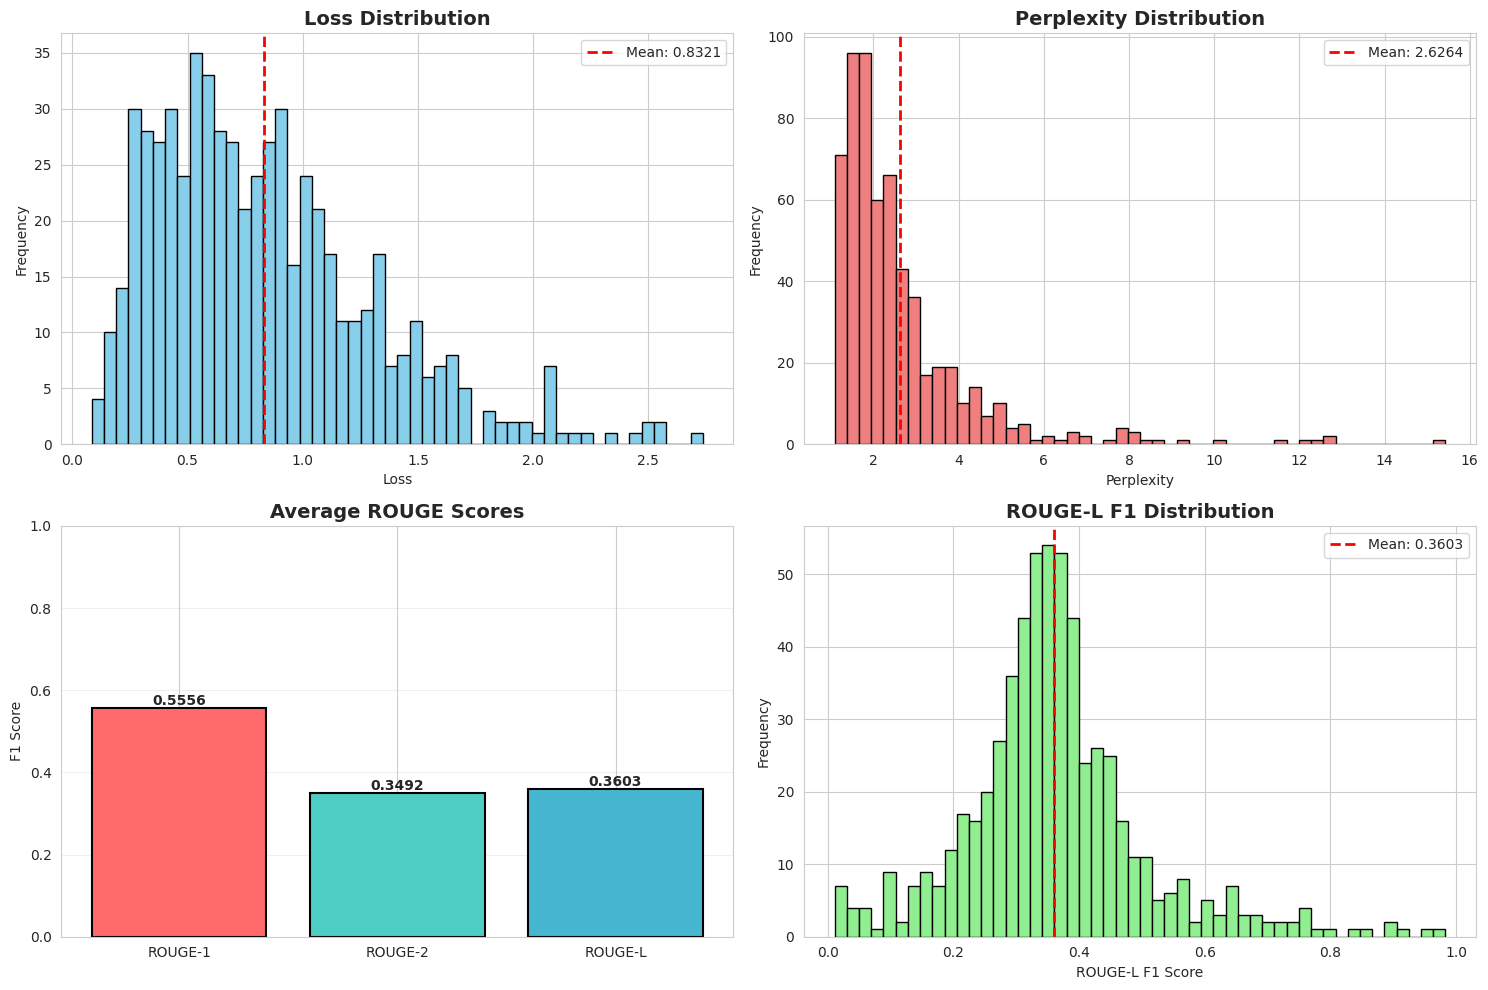

📊 Plots saved to evaluation_plots.png


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 10)

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Loss distribution
axes[0, 0].hist(results['losses'], bins=50, color='skyblue', edgecolor='black')
axes[0, 0].axvline(avg_loss, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_loss:.4f}')
axes[0, 0].set_title('Loss Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Loss')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()

# Plot 2: Perplexity distribution
axes[0, 1].hist(results['perplexities'], bins=50, color='lightcoral', edgecolor='black')
axes[0, 1].axvline(avg_perplexity, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_perplexity:.4f}')
axes[0, 1].set_title('Perplexity Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Perplexity')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

# Plot 3: ROUGE scores comparison
rouge_scores = [avg_rouge1, avg_rouge2, avg_rougeL]
rouge_labels = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

bars = axes[1, 0].bar(rouge_labels, rouge_scores, color=colors, edgecolor='black', linewidth=1.5)
axes[1, 0].set_title('Average ROUGE Scores', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('F1 Score')
axes[1, 0].set_ylim(0, 1)
axes[1, 0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, score in zip(bars, rouge_scores):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{score:.4f}',
                    ha='center', va='bottom', fontweight='bold')

# Plot 4: ROUGE-L distribution
axes[1, 1].hist(results['rougeL_f'], bins=50, color='lightgreen', edgecolor='black')
axes[1, 1].axvline(avg_rougeL, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_rougeL:.4f}')
axes[1, 1].set_title('ROUGE-L F1 Distribution', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('ROUGE-L F1 Score')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('evaluation_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("📊 Plots saved to evaluation_plots.png")

## 11. Example Predictions

In [14]:
# Show some example predictions
num_examples = 5

print("="*80)
print(f"📝 EXAMPLE PREDICTIONS (First {num_examples} samples)")
print("="*80)

for i in range(min(num_examples, len(results['predictions']))):
    print(f"\n{'='*80}")
    print(f"Example {i+1}:")
    print(f"{'='*80}")

    # Input
    example = test_data[i]
    print(f"\n📥 INPUT:")
    print(f"Instruction: {example['instruction']}")
    print(f"Question: {example['input'][:200]}...")

    # Reference
    print(f"\n✅ REFERENCE:")
    print(f"{results['references'][i][:300]}...")

    # Prediction
    print(f"\n🤖 PREDICTION:")
    print(f"{results['predictions'][i][:300]}...")

    # Metrics for this example
    print(f"\n📊 METRICS:")
    print(f"   Loss: {results['losses'][i]:.4f}")
    print(f"   Perplexity: {results['perplexities'][i]:.4f}")
    print(f"   ROUGE-1: {results['rouge1_f'][i]:.4f}")
    print(f"   ROUGE-2: {results['rouge2_f'][i]:.4f}")
    print(f"   ROUGE-L: {results['rougeL_f'][i]:.4f}")

print(f"\n{'='*80}")

📝 EXAMPLE PREDICTIONS (First 5 samples)

Example 1:

📥 INPUT:
Instruction: Trả lời câu hỏi pháp luật sau:
Question: Bố thường xuyên đánh mẹ khiến cuộc sống gia đình tôi không hạnh phúc, căng thẳng nhiều năm qua. Chúng tôi giờ đã trưởng thành, nhiều lần khuyên mẹ ly hôn để được giải thoát nhưng bà không đồng ý. Chún...

✅ REFERENCE:
Theo Điều 51 Luật Hôn nhân và Gia đình năm 2014 (có hiệu lực từ ngày 1/1/2015), quyền yêu cầu giải quyết ly hôn được quy định như sau: 1. Vợ, chồng hoặc cả hai người có quyền yêu cầu tòa án giải quyết ly hôn. 2. Cha, mẹ, người thân thích khác có quyền yêu cầu tòa án giải quyết ly hôn khi một bên vợ,...

🤖 PREDICTION:
Cán bộ, công chức, viên chức và những người khác đang công tác trong các cơ quan Nhà nước, tổ chức chính trị, tổ chức chính trị - xã hội… không được phép làm đơn ly hôn cho bố mẹ mình. Bởi vậy, để giải quyết vướng mắc trên, gia đình bạn có thể thực hiện theo một trong hai cách sau: 1. Bố, mẹ bạn có ...

📊 METRICS:
   Loss: 1.0811
   Perplexity: 

## 12. Save Detailed Results

In [15]:
# Save detailed results to JSONL
detailed_results_path = 'detailed_evaluation_results.jsonl'

with open(detailed_results_path, 'w', encoding='utf-8') as f:
    for i in range(len(results['predictions'])):
        result_item = {
            'id': i,
            'instruction': test_data[i]['instruction'],
            'input': test_data[i]['input'],
            'reference': results['references'][i],
            'prediction': results['predictions'][i],
            'metrics': {
                'loss': float(results['losses'][i]),
                'perplexity': float(results['perplexities'][i]),
                'rouge1_f1': float(results['rouge1_f'][i]),
                'rouge2_f1': float(results['rouge2_f'][i]),
                'rougeL_f1': float(results['rougeL_f'][i]),
            }
        }
        f.write(json.dumps(result_item, ensure_ascii=False) + '\n')

print(f"💾 Detailed results saved to {detailed_results_path}")
print(f"📊 Saved {len(results['predictions'])} predictions with metrics")

💾 Detailed results saved to detailed_evaluation_results.jsonl
📊 Saved 600 predictions with metrics


## 13. Upload Results to DigitalOcean Spaces (Optional)

In [16]:
# Upload results back to Spaces
from datetime import datetime

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
results_prefix = f"evaluation_results/{timestamp}/"

files_to_upload = [
    ('evaluation_results.json', f'{results_prefix}evaluation_results.json'),
    ('detailed_evaluation_results.jsonl', f'{results_prefix}detailed_evaluation_results.jsonl'),
    ('evaluation_plots.png', f'{results_prefix}evaluation_plots.png'),
]

print(f"📤 Uploading results to Spaces: {results_prefix}")

for local_file, spaces_path in files_to_upload:
    try:
        client.upload_file(local_file, DO_SPACES_BUCKET, spaces_path)
        print(f"   ✅ Uploaded {local_file} to {spaces_path}")
    except Exception as e:
        print(f"   ❌ Failed to upload {local_file}: {e}")

print(f"\n✅ All results uploaded to: {results_prefix}")

📤 Uploading results to Spaces: evaluation_results/20251111_194047/
   ✅ Uploaded evaluation_results.json to evaluation_results/20251111_194047/evaluation_results.json
   ✅ Uploaded detailed_evaluation_results.jsonl to evaluation_results/20251111_194047/detailed_evaluation_results.jsonl
   ✅ Uploaded evaluation_plots.png to evaluation_results/20251111_194047/evaluation_plots.png

✅ All results uploaded to: evaluation_results/20251111_194047/


## 14. Summary & Interpretation

### Metrics Interpretation:

#### 1. **Loss**
- Giá trị thấp = tốt (< 1.0 là rất tốt)
- Đo sự khác biệt giữa prediction và ground truth

#### 2. **Perplexity**  
- Giá trị thấp = tốt (< 10 là excellent, < 20 là good)
- Đo độ "surprised" của model với dữ liệu
- Perplexity = exp(loss)

#### 3. **ROUGE Scores** (0-1, cao hơn = tốt hơn)
- **ROUGE-1**: Overlap của từ đơn (unigrams)
- **ROUGE-2**: Overlap của cụm 2 từ (bigrams) - đo fluency
- **ROUGE-L**: Longest Common Subsequence - đo cấu trúc câu

**Thang đánh giá ROUGE:**
- 0.4-0.5: Good
- 0.5-0.6: Very Good  
- \>0.6: Excellent

### Recommended Benchmarks cho Vietnamese Legal QA:
- Loss: < 1.5
- Perplexity: < 15
- ROUGE-L: > 0.35